# NETWORKS-TWITTER ANALYSIS

## SET-UP

In [1]:
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy.sparse as sp
import scipy.stats as stats

import umap
import hdbscan

import stopwordsiso

import warnings
warnings.filterwarnings('ignore')

from numpy import dot
from numpy.linalg import norm
from langdetect import detect
from sentence_transformers import SentenceTransformer, util
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from itertools import combinations

In [2]:
dtype_dict = {'id': str, 'author_id': str,'ref_id': str, 'ref_author_id': str, "tw_id": str}

#### cluster naming

## Based on https://towardsdatascience.com/creating-a-class-based-tf-idf-with-scikit-learn-caea7b15b858 but updated to work with new package versions (scikit-learn and pandas)
class CTFIDF(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDF, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

    def get_top_x_labels(self, docs_per_class, words, ctfidf, x):
        top_words_per_class = {}
        for label in docs_per_class['Class']:
            if label != "climate" and label != "change":
                # Get the index corresponding to the label
                index = docs_per_class[docs_per_class['Class'] == label].index[0]
                # Get the top x words for this label
                top_words_per_class[label] = ' '.join([words[index] for index in ctfidf[index].argsort()[-x:]])
        return top_words_per_class


#### text processing
def preprocess_articles(data, col_name, stopword_filtering=True):
    data[col_name] = data.apply(lambda row: clean_text_topic(row[col_name], stopword_filtering), axis=1)
    return data


def clean_text_topic(text, stopword_filtering):
    custom_words_to_filter = ["climate", "change", "rt"] 
    
    language = detect(text) 
    words_to_filter = custom_words_to_filter
    
    if stopword_filtering and stopwordsiso.has_lang(language):
        words_to_filter.extend(stopwordsiso.stopwords(language))
    words_to_filter = list(set(words_to_filter))
    
    cleaned_text = ' '.join([word for word in text.split() if word.lower() not in words_to_filter])
    
    return cleaned_text


### function to upload

def str_to_list(s):
    # Remove '[' and ']' from the string and split by ','
    s = s.strip('[]').split(',')
    # Convert each element to int
    return [float(x) for x in s]


##UMAP
def process_umap(df):
    df = df.drop_duplicates(subset=['text', 'ref_text', 'tw_id', 'ref_id', 'type', 'lemen_text',
                                    'lemen_ref', 'tags_ref', 'sep_tags_ref', 'tags_text', 'sep_tags_text'])
    embeddings_vector = np.vstack(df["text_embedding"].apply(lambda x: np.array(x)).to_numpy())
    reducer = umap.UMAP(n_components=5, n_neighbors=2, min_dist=0, metric='cosine')
    umap_embeddings = reducer.fit_transform(embeddings_vector)
    df["umap_embedding"] = [umap_embeddings[i] for i in range(len(umap_embeddings))]
    return df, umap_embeddings


##GET TOP HASHTAGS
def get_top_words(words):
    word_counts = pd.Series(words).explode().value_counts() 
    if "climate" in word_counts:
        del word_counts["climate"]
    elif "climatechange" in word_counts: 
        del word_counts["climatechange"]
    top_words = word_counts.index[:3] 
    return list(top_words)

In [100]:
def topic_modeling(nation):

    emb = pd.read_csv(filepath+nation+"_embeddings.csv", dtype=dtype_dict, converters={'text_embedding': str_to_list})

    #DIMENSIONALITY REDUCTION
    if nation == "ge":
        half_len = len(emb) // 2
        df_part1 = emb.iloc[:half_len]
        df_part2 = emb.iloc[half_len:]

        processed_part1, umap_embeddings1 = process_umap(df_part1)
        processed_part2, umap_embeddings2 = process_umap(df_part2)

        emb = pd.concat([processed_part1, processed_part2])
        umap_embeddings = np.concatenate((umap_embeddings1, umap_embeddings2), axis=0)

    else:
        emb, umap_embeddings = process_umap(emb)


    #CLUSTERING 
    clusterer = hdbscan.HDBSCAN(core_dist_n_jobs=-1, min_samples = 1, min_cluster_size = 5, gen_min_span_tree=True).fit(umap_embeddings) 
    clusterer.fit(umap_embeddings)
    cluster_labels_hdb = clusterer.labels_ 
    emb['cluster'] = cluster_labels_hdb

    # print("Number of clusters HDBSCAN:", cluster_labels_hdb.max()+1)
    # print("Percentage of articles without a topic: ", round(100*(np.count_nonzero(cluster_labels_hdb == -1)/cluster_labels_hdb.size), 2), "%", sep='')
    

    #CLUSTER NAMING
    docs = pd.DataFrame({'Document': emb["lemen_text"], 'Class': emb["cluster"]})
    docs_per_class = docs.groupby(['Class'], as_index=False).agg({'Document': ' '.join})

    count_vectorizer = CountVectorizer().fit(docs_per_class.Document)
    count = count_vectorizer.transform(docs_per_class.Document)
    words = count_vectorizer.get_feature_names_out()

    ctfidf = CTFIDF().fit_transform(count, n_samples=len(docs)).toarray()
    words_per_class = CTFIDF().get_top_x_labels(docs_per_class, words, ctfidf, 10)

    emb['name_cluster'] = emb["cluster"].map(words_per_class)

    #DOWNLOAD
    emb.to_csv('C:\\Users\\isabe\\Desktop\\RESEARCH PROJECT\\Twitter\\'+nation+'_clusters.csv', index=False)
    
    return emb

  
    ####################################################################################################

    
def merge_topics(nation, emb, level = False):

    #ACCOUNTS
    columns_to_read = ['id', 'author_id']
    ids = pd.read_csv(filepath+nation+"_edgelist.csv", usecols=columns_to_read, dtype=dtype_dict)


    #ORGANIZATIONS
    columns_to_read = ["org", 'id', 'level']

    org = pd.read_csv(filepath+nation+"_all_accounts.csv", usecols=columns_to_read, dtype=dtype_dict)
    org = org.dropna(subset = ("id"))
    if level == True:
        org = org[org["level"] == 0.0]


    #MERGE TWEETS WITH AUTHOR_ID
    columns_to_keep = ['tw_id', 'author_id', 'lemen_text', 'tags_text', 'lang', 'cluster', 'name_cluster']  

    tweets_author = emb.merge(ids, how='inner', left_on='tw_id', right_on='id')[columns_to_keep]
    tweets_author = tweets_author.drop_duplicates(subset=['tw_id', 'author_id', 'lemen_text', 'cluster'])

    
    #MERGE WITH ORGANIZATIONS ID
    tweets_org= tweets_author.merge(org[["org", "id"]], how='inner', left_on='author_id', right_on='id')
    tweets_org = tweets_org.drop(columns=['id'])


    #HASHTAGS
    tweets_org_h = tweets_org.dropna(subset=['tags_text'])
    tweets_org_h['hashtags'] = tweets_org_h['tags_text'].apply(lambda x: [word.lower().strip('#') for word in x.split() if word.startswith('#')])

    hashtags_df = tweets_org_h.groupby('org')['hashtags'].agg(lambda x: set(y for sublist in x for y in sublist)).reset_index()
    hashtags_df.columns = ['org', 'hashtags']

    hashtags_cl = tweets_org_h.groupby('name_cluster')['hashtags'].agg(get_top_words).reset_index()
    hashtags_cl.columns = ['topic', 'hashtags']
    hashtags_cl['value_count'] = tweets_org_h.groupby('name_cluster').size().reset_index(drop=True)


    #STATS ON CLUSTERS
    # n_clusters = emb['cluster'].max() + 1
    n_clusters = len(tweets_org["cluster"].unique())

    # noise = len(emb[emb['cluster'] == -1])
    noise = len(tweets_org[tweets_org['cluster'] == -1])
    total_rows = len(tweets_org)
    percentage = (noise / total_rows) * 100

    print("Number of clusters:", n_clusters)
    print("Percentage of articles without a topic: ", np.round(percentage, 2), "%")
    print()


    #POST PROCESSING ON TOP 5 CLUSTERS
    valid_clusters = hashtags_cl.loc[hashtags_cl['value_count'] != hashtags_cl['value_count'].max()] 
    top_5_clusters = valid_clusters.loc[valid_clusters['value_count'].nlargest(5).index]
    top_5_hashtags = hashtags_cl[hashtags_cl['value_count'].isin(top_5_clusters['value_count'])][['topic', 'hashtags']]

    unique_df = pd.DataFrame(top_5_hashtags)
    unique_df = preprocess_articles(unique_df, 'topic')

    pd.set_option('display.max_colwidth', None)
    print(unique_df)
    print()
    print(f"There are {top_5_clusters['value_count'].tolist()} tweets in the top 5 clusters")
    print()


    #CREATE LIST OF CLUSTERS FOR ORG
    cl_orgs = tweets_org[tweets_org["cluster"] != -1].groupby('org')['cluster'].agg(lambda x: list(set(x))).reset_index()
    print(f"There are {len(tweets_org)} tweets")
    print(f"There are {len(cl_orgs)} organizations")


    #CREATE DF WITH TOPICS AND HASHTAGS IN COMMON
    pairs = list(combinations(cl_orgs['org'], 2))
    results_topics = []
    results_hashtags = []

    for org1, org2 in pairs:
        common_clusters = len(cl_orgs.loc[(cl_orgs['org'] == org1) | (cl_orgs['org'] == org2), 'cluster'].explode().value_counts())
        common_hashtags = len(hashtags_df.loc[(hashtags_df['org'] == org1) | (hashtags_df['org'] == org2), 'hashtags'].explode().value_counts())
        results_topics.append([org1, org2, common_clusters])
        results_hashtags.append([org1, org2, common_hashtags])

    topics = pd.DataFrame(results_topics, columns=['source', 'target', 'topics'])
    hashtags = pd.DataFrame(results_hashtags, columns=['source', 'target', 'hashtags'])

    return topics, hashtags


    #############################################################################################################


def networks(nation, topics, hashtags):
    #NETWORKS
    file = "C:\\Users\\isabe\\Desktop\\EIT\\AALTO\\1.1 RESEARCH PROJECT\\COMPON_surveys_data_integrated_0108AK.xlsx"
    network_file = pd.read_excel(file, sheet_name = "network list")
    nation= nation.upper()
    all_graphs = {}

    for index, row in network_file.iterrows():    
        if row[nation] == 1:
            name = nation+"_"+row["Network "]+"L"
            df = pd.read_excel(file, sheet_name = name)
            
            if "N3" in name:
                g = nx.Graph()
            else: 
                g = nx.DiGraph()
                
            g.add_edges_from(df.values)
            all_graphs[name] = g


    #DISTANCES
    all_distances = {}

    for network, graph in all_graphs.items():
        nodes = list(graph.nodes())
        net = network.split('_')[1][:-1]

        nodes1 = []
        nodes2 = []
        distances = []
        
        for node1 in range(len(nodes)):
            for node2 in range(len(nodes)):
                if node1 == node2:
                    distance = 0
                else:
                    try:
                        distance = nx.shortest_path_length(graph, source=nodes[node1], target=nodes[node2])
                    except nx.NetworkXNoPath:
                        distance = -1 

                nodes1.append(nodes[node1])
                nodes2.append(nodes[node2])
                distances.append(distance)        

        df_dist = pd.DataFrame({'org1': nodes1, 'org2': nodes2, 'shortest_path': distances})                                           
        all_distances[net] = df_dist


    #MERGE SHORTEST PATH AND TOPICS AND HASHTAGS
    all_metrics = {}

    for net, df in all_distances.items():
        metrics = pd.merge(topics, df, left_on=['source', 'target'], right_on=['org1', 'org2'], how='inner')
        metrics.drop(['org1', 'org2'], axis=1, inplace=True)
        metrics =  pd.merge(hashtags, metrics, on=['source', 'target'], how='inner')
        all_metrics[net] = metrics


    #TEST NORMALITY
    names = ["topics", "hashtags"]
    ass = {"topics": {}, "hashtags": {}}

    for n in names:
        # print(n)
        # print()
        for net, df in all_metrics.items():
            satisfied = []
            # print(net)
            df_filtered = df[df['shortest_path'] != -1]
            df_filtered['shortest_path_cat'] = pd.Categorical(df_filtered['shortest_path'])
            cat_30 = [category for category in df_filtered['shortest_path_cat'].unique() if len(df_filtered[df_filtered['shortest_path_cat'] == category]) >= 10]
            df_30 = df_filtered[df_filtered['shortest_path_cat'].isin(cat_30)]

            # print(df_filtered["shortest_path_cat"].value_counts())

            #normality
            for category in df_30['shortest_path_cat'].unique():
                category_data = df_30[df_30['shortest_path_cat'] == category]

                normality_stat, normality_pvalue = stats.shapiro(category_data[n])
                if normality_pvalue > 0.05:
                    # print(f"Shortest path: {category} NOT normal", normality_pvalue)
                    if category == df_30['shortest_path_cat'].unique()[-1]:
                        satisfied.append("yes")
                else:
                    #print(f"Shortest path: {category} normal")
                    satisfied.append("yes")
            
            #equality of variances
            bartlett_stat, bartlett_pvalue = stats.bartlett(*[df_30[df_30['shortest_path_cat'] == category][n] for category in df_30['shortest_path_cat'].unique()])
            
            if bartlett_pvalue > 0.05:
                pass
                # print("Equal Variance NOT Satisfied", bartlett_pvalue)
            else:
                #print("Equal Variance Satisfied")
                satisfied.append("yes")
            
            if len(satisfied) == len(df_30['shortest_path_cat'].unique()) + 1:
                # print("Assumptions met")
                ass[n][net] = 1
            else:
                # print("Assumptions NOT met")
                ass[n][net] = 0
            
            # print()


    #PLOT
    sns.set_theme()

    for n in names:
        print(n)
        print()
        for net, df in all_metrics.items():
            df_filtered = df[df['shortest_path'] != -1]
            df_filtered['shortest_path_cat'] = pd.Categorical(df_filtered['shortest_path'])
            cat_30 = [category for category in df_filtered['shortest_path_cat'].unique() if len(df_filtered[df_filtered['shortest_path_cat'] == category]) >= 10]
            df_30 = df_filtered[df_filtered['shortest_path_cat'].isin(cat_30)]

            sns.scatterplot(data=df_30, x='shortest_path', y=n)
            plt.ylabel('Shared '+n)
            plt.xlabel('Shortest Path')
            plt.xticks(np.arange(1, df_30["shortest_path"].max() + 1, 1))
            
            if ass[n][net] == 1:
                mean_values = df_30.groupby('shortest_path')[n].mean()
                plt.scatter(mean_values.index, mean_values.values, color='red', label='Mean', s=30)
            else:
                median_values = df_30.groupby('shortest_path')[n].median()
                plt.scatter(median_values.index, median_values.values, color='red', label='Median', s=30)
                
            for index, row in network_file.iterrows():
                if net == row["Network "]:
                    title = row["Description"]

            plt.title(nation + " " + net + " - " + title+ "\n" + n)
            plt.legend()
            plt.show()


    #T TESTING
    for n in names:
        print(n)
        print()
        for net, df in all_metrics.items():
            df_filtered = df[df['shortest_path'] != -1]
            df_filtered['shortest_path_cat'] = pd.Categorical(df_filtered['shortest_path'])
            cat_30 = [category for category in df_filtered['shortest_path_cat'].unique() if len(df_filtered[df_filtered['shortest_path_cat'] == category]) >= 10]
            df_30 = df_filtered[df_filtered['shortest_path_cat'].isin(cat_30)]
            grouped_data = [df_30[df_30['shortest_path_cat'] == category][n] for category in sorted(df_30['shortest_path_cat'].unique())]
            # print(grouped_data)
            
            print(net)

            if ass[n][net] == 1:
                for i in range(len(grouped_data)):
                    for j in range(i + 1, len(grouped_data)):
                        group1 = grouped_data[i]
                        group2 = grouped_data[j]
                        
                        mean_group1 = group1.mean()
                        mean_group2 = group2.mean()
                        _, p_value = stats.ttest_ind(group1, group2, alternative='greater')    
                        print(f"T-test between {sorted(df_30['shortest_path_cat'].unique())[i]} and {sorted(df_30['shortest_path_cat'].unique())[j]}:")
                    
                        print("P-value:", np.round(p_value, 4))
                        print("")


            else:
                for i in range(len(df_30['shortest_path_cat'].unique())):
                    for j in range(i + 1, len(df_30['shortest_path_cat'].unique())):
                        group1 = grouped_data[i]
                        group2 = grouped_data[j]

                        mwu_result = stats.mannwhitneyu(group1, group2, alternative='greater')
                        median_group1 = group1.median()
                        median_group2 = group2.median()
                        
                        print(f"Mann-Whitney U test between {sorted(df_30['shortest_path_cat'].unique())[i]} and {sorted(df_30['shortest_path_cat'].unique())[j]}:")
                            
                        print("P-value:", np.round(mwu_result.pvalue, 4))
                        print("")
        
            print()





## AUSTRALIA

In [ ]:
#au_emb = topic_modeling("au")
au_emb = pd.read_csv(filepath+"au_clusters.csv", dtype=dtype_dict)

### ALL

In [19]:
au_topics, au_hashtags = merge_topics("au", au_emb)

Number of clusters: 7598
Percentage of articles without a topic:  12.88 %

                                                                                               topic  \
1180                  care korea gwadar cancer late simonjnicholas financialtime kurri pakistan coal   
2836                                                     future climatecouncil reduce subma emission   
3021  govt lilydambrosiomp reduction vicclimatesolution interim springst emissions victargets target   
3892                lead opportunty organise vic fed therealewbank lilydambrosiomp springst victoria   
7327                               wreck morrison climatecouncil policy federal australia government   

                                              hashtags  
1180                           [coal, pakistan, covid]  
2836  [decarbonise, allenergyau, energymanagementzone]  
3021       [springst, vicclimatesolutions, victargets]  
3892             [springst, auspol, climateimpactsvic]  
7327           

topics



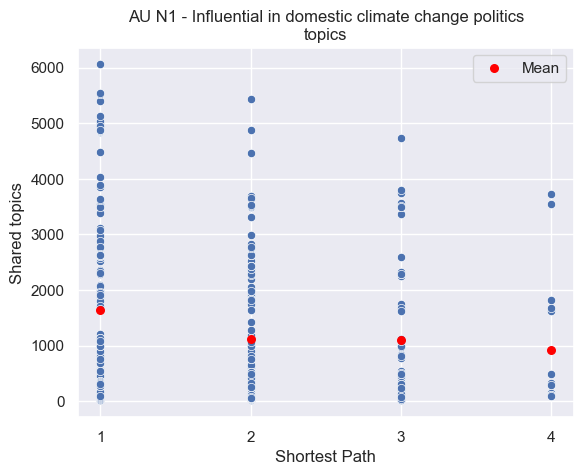

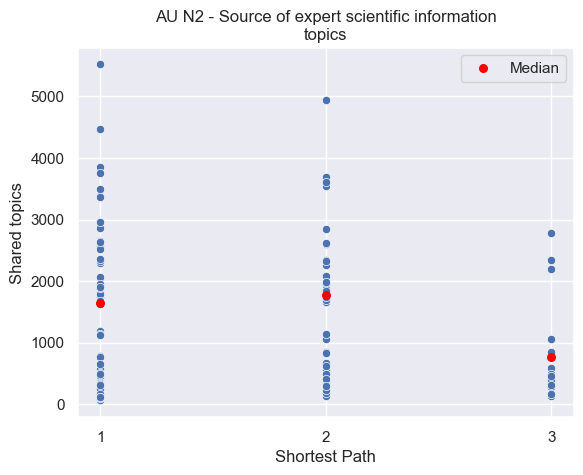

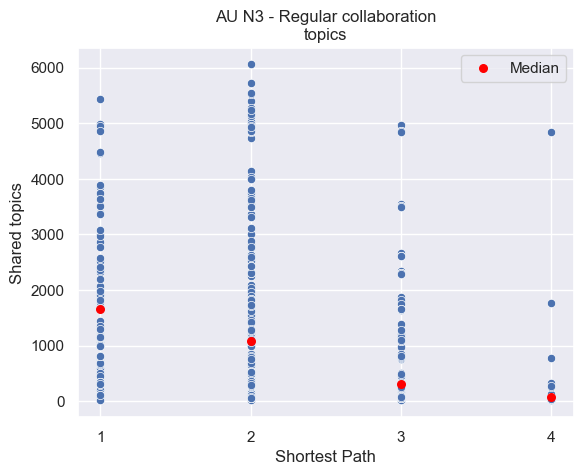

hashtags



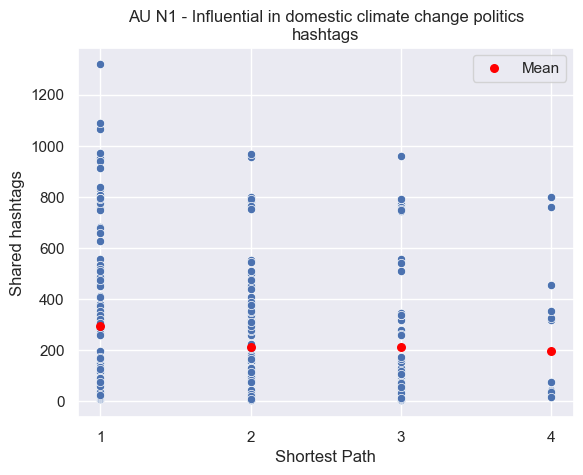

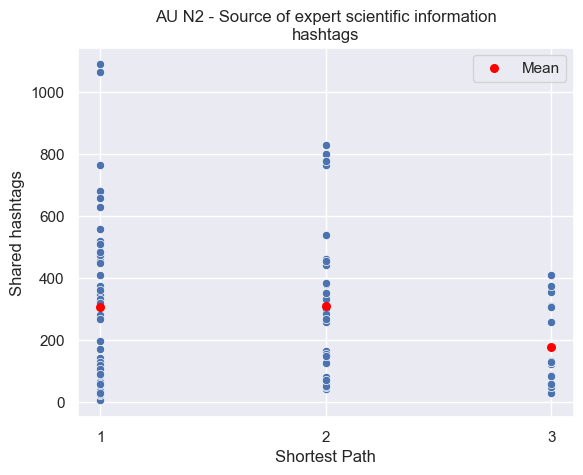

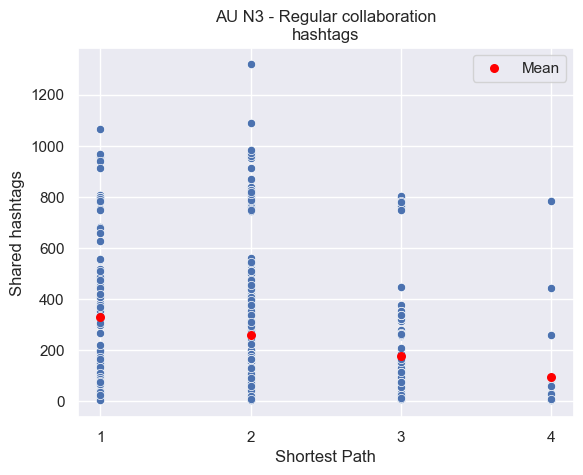

topics

N1
T-test between 1 and 2:
P-value: 0.0

T-test between 1 and 3:
P-value: 0.0027

T-test between 1 and 4:
P-value: 0.0268

T-test between 2 and 3:
P-value: 0.4699

T-test between 2 and 4:
P-value: 0.2339

T-test between 3 and 4:
P-value: 0.2842


N2
Mann-Whitney U test between 1 and 2:
P-value: 0.6992

Mann-Whitney U test between 1 and 3:
P-value: 0.1075

Mann-Whitney U test between 2 and 3:
P-value: 0.0343


N3
Mann-Whitney U test between 1 and 2:
P-value: 0.0041

Mann-Whitney U test between 1 and 3:
P-value: 0.0

Mann-Whitney U test between 1 and 4:
P-value: 0.0

Mann-Whitney U test between 2 and 3:
P-value: 0.0

Mann-Whitney U test between 2 and 4:
P-value: 0.0

Mann-Whitney U test between 3 and 4:
P-value: 0.0001


hashtags

N1
T-test between 1 and 2:
P-value: 0.0004

T-test between 1 and 3:
P-value: 0.0139

T-test between 1 and 4:
P-value: 0.0763

T-test between 2 and 3:
P-value: 0.5311

T-test between 2 and 4:
P-value: 0.3682

T-test between 3 and 4:
P-value: 0.3842


N2


In [101]:
networks("au", au_topics, au_hashtags)

### LEVEL 0

In [50]:
au_topics0, au_hashtags0 = merge_topics("au", au_emb, level = True)

Number of clusters: 6450
Percentage of articles without a topic:  12.16 %

                                                                                                                        topic  \
482                                              asthmaaustralia wellbeing framework healthy_climate national strategy health   
1257                                                                   coast jojowr healthy_climate doctor heat impact health   
1995                                         export african miner africa southafrica south coal businesslivesa simonjnicholas   
3619  newcastleherald mikeyslezak mcannonbrookes renew_economy simonahac can_australia murpharoo p_hannam abcnews adamlmorton   
5871                                                        wreck morrison climatecouncil policy federal australia government   

                                      hashtags  
482                                         []  
1257  [heathealth, climatehealth, extremeheat]  
199

topics

N1
Assumptions met

N2
Assumptions met

N3
Assumptions met

hashtags

N1
Equal Variance NOT Satisfied 0.08857956963348372
Assumptions NOT met

N2
Shortest path: 3 NOT normal 0.08693744242191315
Assumptions met

N3
Assumptions met

topics



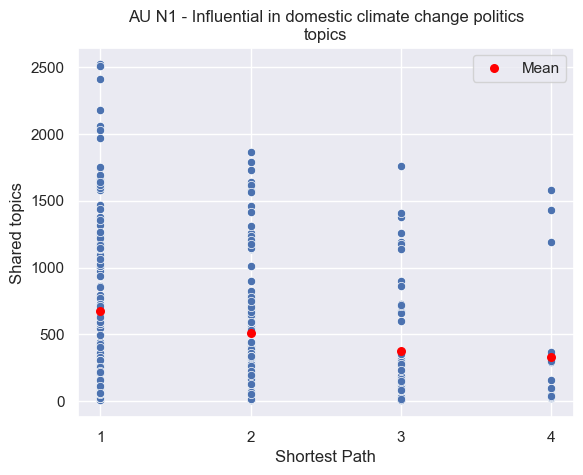

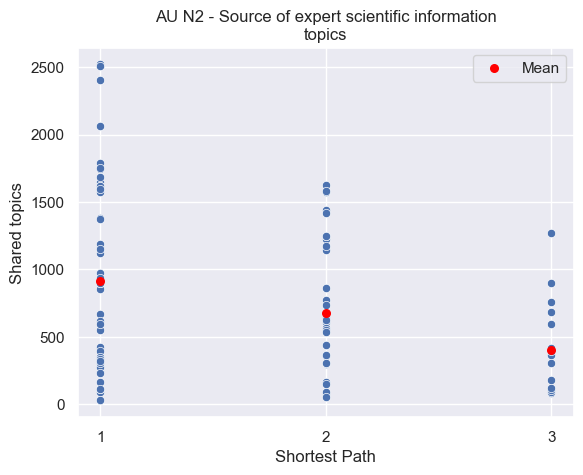

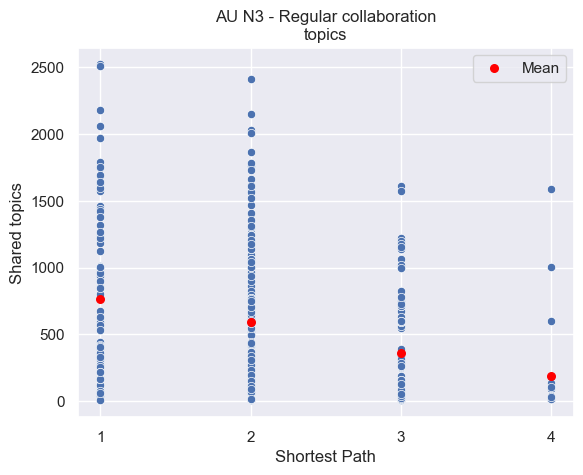

hashtags



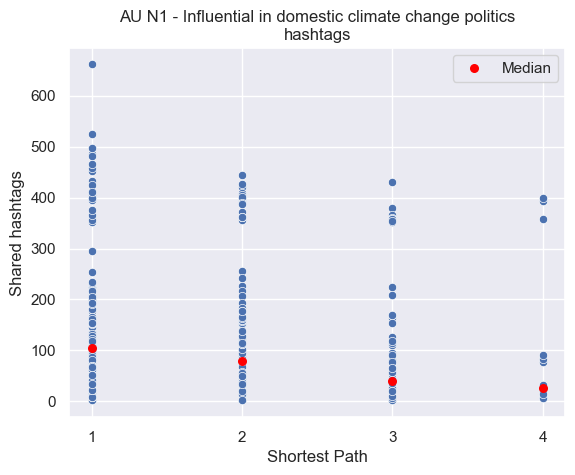

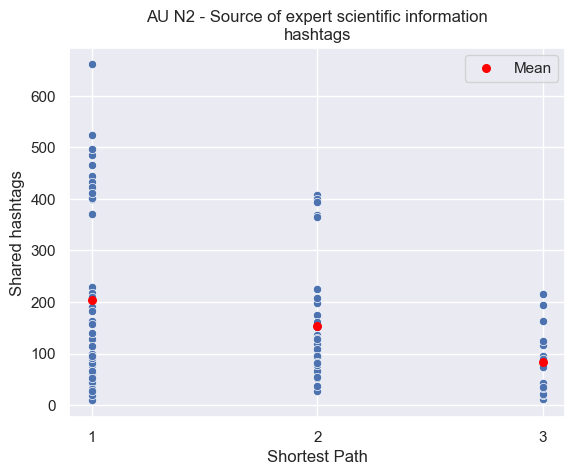

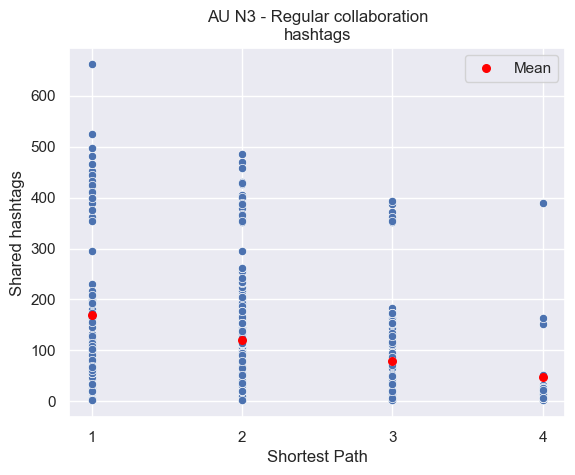

topics

N1
T-test between 1 and 2:
Mean 1 > mean 2
P-value: 0.0042994228435304475

T-test between 1 and 3:
Mean 1 > mean 3
P-value: 0.00011067983126747322

T-test between 1 and 4:
Mean 1 > mean 4
P-value: 0.02268421733642075

T-test between 2 and 3:
Mean 2 > mean 3
P-value: 0.032262682432491196


N2
T-test between 1 and 3:
Mean 1 > mean 3
P-value: 0.00722752019706731

T-test between 2 and 3:
Mean 2 > mean 3
P-value: 0.03768781661869314


N3
T-test between 2 and 3:
Mean 2 > mean 3
P-value: 1.7158920821439086e-06

T-test between 2 and 1:
Mean 2 < mean 1
P-value: 0.005474325917705979

T-test between 2 and 4:
Mean 2 > mean 4
P-value: 0.0005833258735851738

T-test between 3 and 1:
Mean 3 < mean 1
P-value: 5.582317447410851e-10

T-test between 1 and 4:
Mean 1 > mean 4
P-value: 6.503307009761547e-05


hashtags

N1
Mann-Whitney U test between 1 and 3:
Median 1 > median 3
P-value: 0.00020033030890068932

Mann-Whitney U test between 1 and 4:
Median 1 > median 4
P-value: 0.006520739272069028

Man

In [43]:
networks("au", au_topics0, au_hashtags0)

In [51]:
ca_topics.head()

,source,target,topics
0,CA001,CA002,51
1,CA001,CA003,59
2,CA001,CA004,71
3,CA001,CA005,57
4,CA001,CA007,53


In [52]:
ca_topics0.head()

,source,target,topics
0,CA001,CA002,51
1,CA001,CA003,59
2,CA001,CA004,71
3,CA001,CA005,57
4,CA001,CA007,53


## CANADA

In [39]:
#ca_emb = topic_modeling("ca")
ca_emb = pd.read_csv(filepath+"ca_clusters.csv", dtype=dtype_dict)

### ALL

In [53]:
ca_topics, ca_hashtags = merge_topics("ca", ca_emb)

Number of clusters: 5220
Percentage of articles without a topic:  11.42 %

                                                                        topic  \
314                                                   civmin dr discuss simon   
1218  create investment grow commit campus positive divest clim severity uoft   
1637                                          réchauffement climat climatique   
1723     ethos ethylene etienne etiquette etobicoke etsy ethnicity 𝜉1 ppcmmxx   
1940       fossil carnivalplc cheat pasture pollution emission cruise zealand   
2324                      urbanlandscape 30under30 waste resilient uvic ready   

                                     hashtags  
314     [climateanxiety, ubcokanagan, ldnont]  
1218                                   [uoft]  
1637  [cop26, climatecrisis, climateambition]  
1723                                [ppcmmxx]  
1940             [parisagreement, fossilfuel]  
2324            [climatechange, 30under30, g]  

There are [29, 28, 2

topics



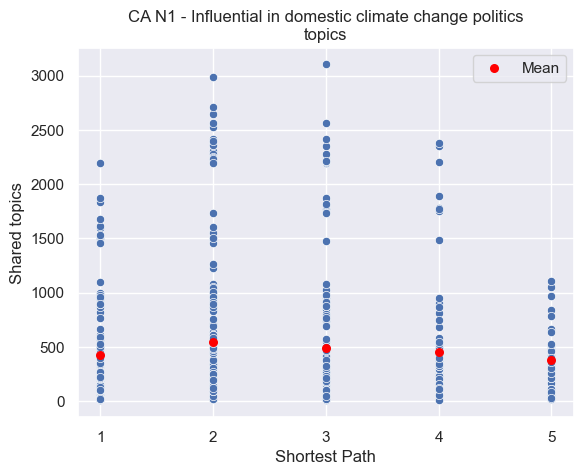

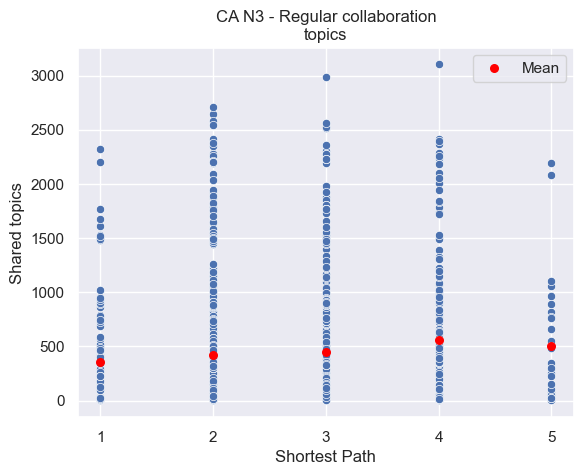

hashtags



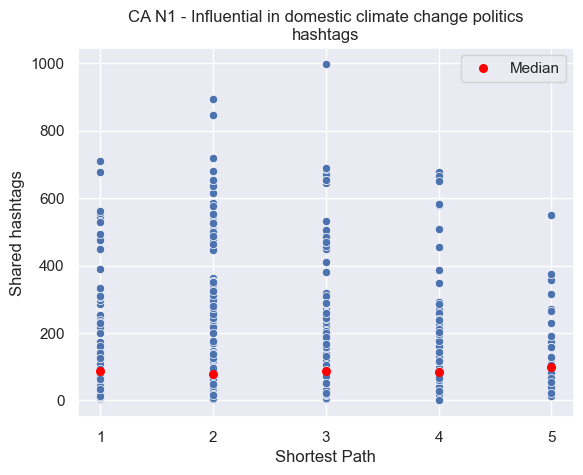

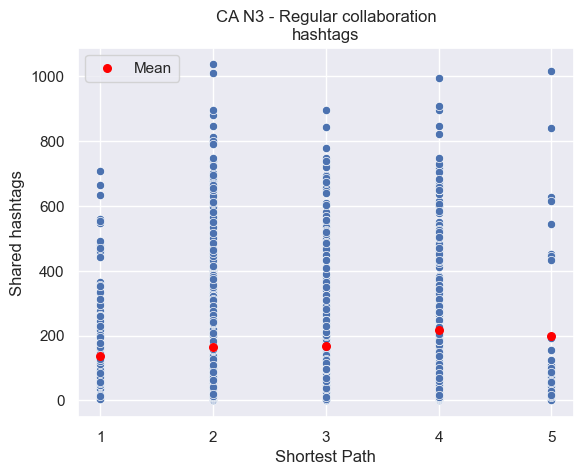

topics

N1
T-test between 1 and 2:
P-value: 0.9726

T-test between 1 and 3:
P-value: 0.8863

T-test between 1 and 4:
P-value: 0.6927

T-test between 1 and 5:
P-value: 0.2813

T-test between 2 and 3:
P-value: 0.208

T-test between 2 and 4:
P-value: 0.1533

T-test between 2 and 5:
P-value: 0.0611

T-test between 3 and 4:
P-value: 0.3183

T-test between 3 and 5:
P-value: 0.1098

T-test between 4 and 5:
P-value: 0.1898


N3
T-test between 1 and 2:
P-value: 0.9381

T-test between 1 and 3:
P-value: 0.9907

T-test between 1 and 4:
P-value: 1.0

T-test between 1 and 5:
P-value: 0.9718

T-test between 2 and 3:
P-value: 0.9349

T-test between 2 and 4:
P-value: 1.0

T-test between 2 and 5:
P-value: 0.8447

T-test between 3 and 4:
P-value: 0.9997

T-test between 3 and 5:
P-value: 0.7407

T-test between 4 and 5:
P-value: 0.3151


hashtags

N1
Mann-Whitney U test between 1 and 2:
P-value: 0.7663

Mann-Whitney U test between 1 and 3:
P-value: 0.6808

Mann-Whitney U test between 1 and 4:
P-value: 0.75

In [102]:
networks("ca", ca_topics, ca_hashtags)

### LEVEL 0

In [55]:
ca_topics0, ca_hashtags0 = merge_topics("ca", ca_emb, level = True)

Number of clusters: 3859
Percentage of articles without a topic:  9.88 %

                                                                                 topic  \
389         brc_canada economy lowcarbon 118 improve win energyefficiency nrcan energy   
884   defundcgl bank fossil tar amp greenwashing enbridge greenwashe r_brooksstand rbc   
1788                                  justin prendre andrewscheer trudeau carbone taxe   
2358                       phase action community local movement fossil fuel safecitie   
2958                           supply amp chain yoga lulu brand factory coal lululemon   
3033      canadiangreens cdnpoli pledge cancel candidate stoptmx mountain trans elxn44   
3282                                         vigueur trudeau carbone andrewscheer taxe   
3443            zev kendraulrich cargo retail ikea amazon shipping ship shipitzerocrew   

                                         hashtags  
389        [energyefficiency, lowcarbon, netzero]  
884   [defu

topics

N1
Equal Variance NOT Satisfied 0.2038085434989376
Assumptions NOT met

N3
Assumptions met

hashtags

N1
Assumptions met

N3
Assumptions met

topics



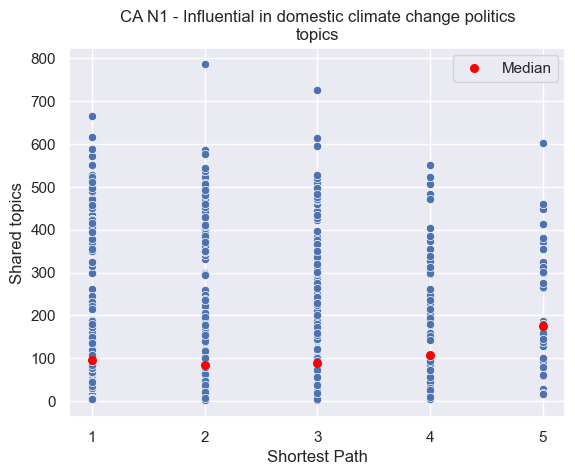

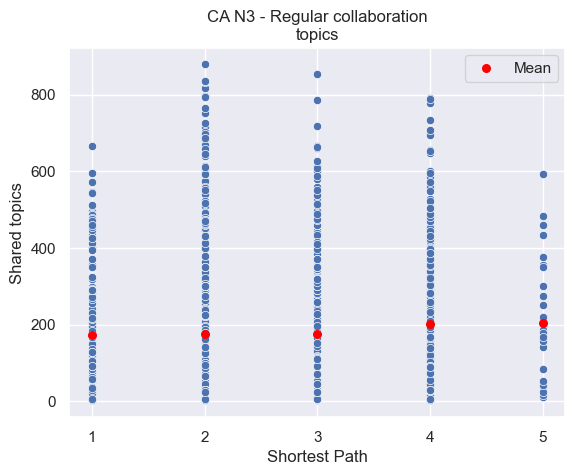

hashtags



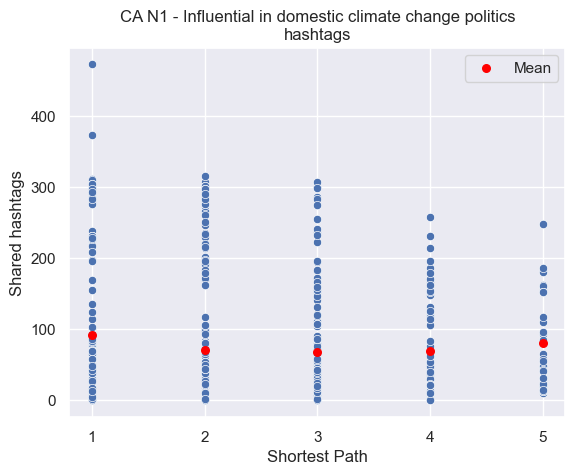

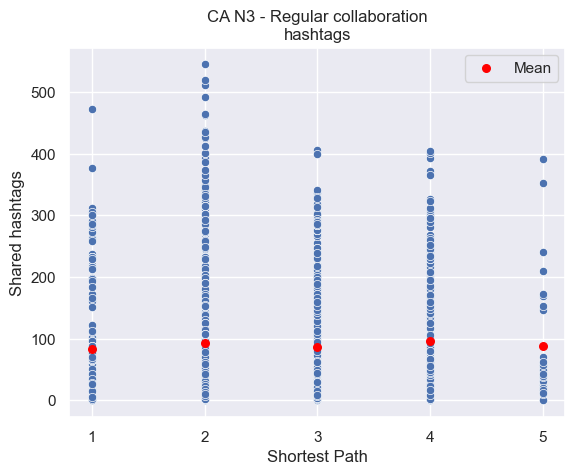

topics

N1
Mann-Whitney U test between 2 and 5:
Median 2 < median 5
P-value: 0.02803037774325047

Mann-Whitney U test between 3 and 5:
Median 3 < median 5
P-value: 0.04999759285054319


N3
T-test between 2 and 4:
Mean 2 < mean 4
P-value: 0.013496768536695325

T-test between 3 and 4:
Mean 3 < mean 4
P-value: 0.008995924905657949


hashtags

N1
T-test between 2 and 1:
Mean 2 < mean 1
P-value: 0.02397753671863114

T-test between 3 and 1:
Mean 3 < mean 1
P-value: 0.019299348942818748


N3



In [56]:
networks("ca", ca_topics0, ca_hashtags0)

## FINLAND

In [58]:
#fi_emb = topic_modeling("fi")
fi_emb = pd.read_csv(filepath+"fi_clusters.csv", dtype=dtype_dict)

### ALL

In [104]:
fi_topics, fi_hashtags = merge_topics("fi", fi_emb)

Number of clusters: 10835
Percentage of articles without a topic:  12.44 %

                                                                                                            topic  \
2435                                                                 hiilen saarasofia vihreiden mä harrilaurikka   
2618                            https temperature anttilip 2016 anomaly 1900 dataviz globalwarme download arrange   
3469                                                                                                                
5165      maapallon ipccraportti hanneleskorhone ilmastotiede ketju ulkona keskilämpötila arviointiraportin lyhyt   
5834  musiikkivideo ilmastonuorilta kuntavaaligallupin virkistysmetsää mmm_fi vihreät hankkeessa töihin peruna365   

                                     hashtags  
2435                     [jatketaan, vihreät]  
2618  [dataviz, climatechange, globalwarming]  
3469   [vasemmisto, kuntavaalit2021, vihreät]  
5165    [ipccraportti, ilmast

topics



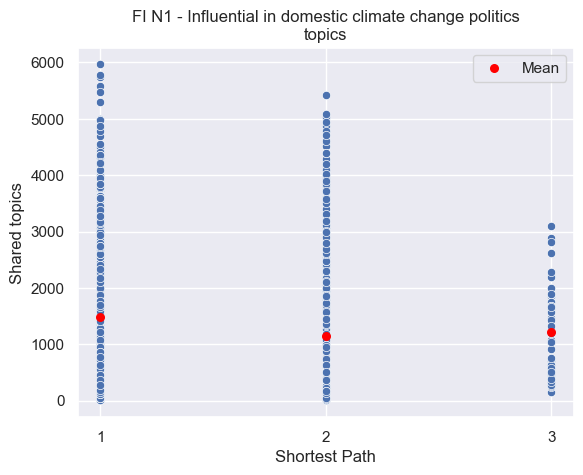

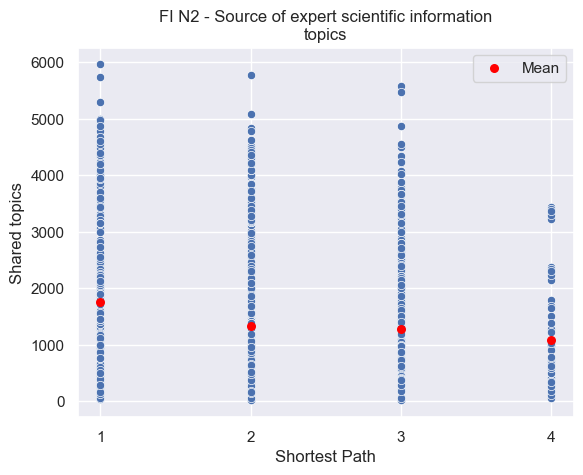

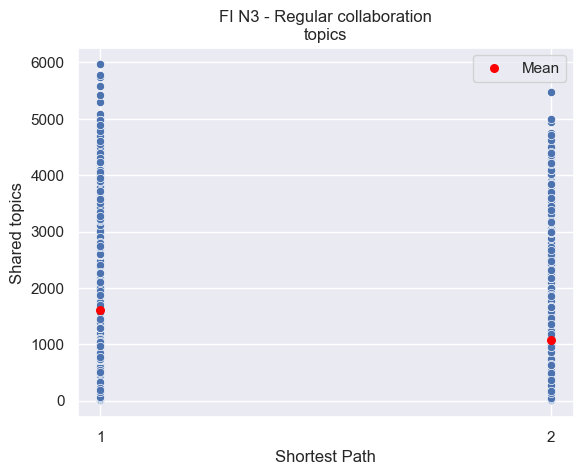

hashtags



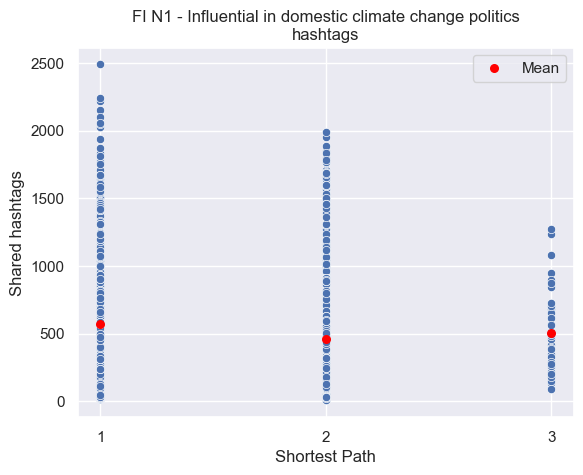

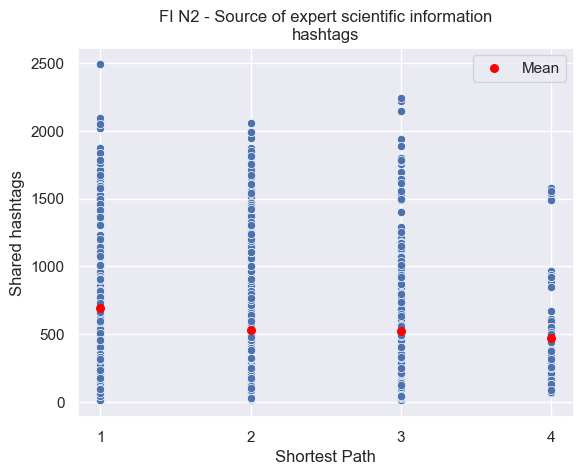

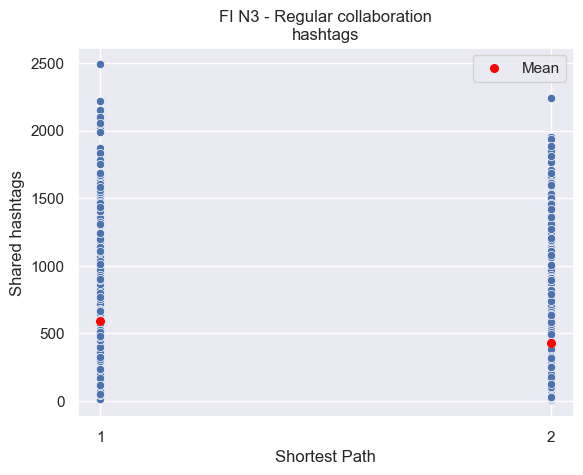

topics

N1
T-test between 1 and 2:
P-value: 0.0

T-test between 1 and 3:
P-value: 0.0391

T-test between 2 and 3:
P-value: 0.6968


N2
T-test between 1 and 2:
P-value: 0.0

T-test between 1 and 3:
P-value: 0.0

T-test between 1 and 4:
P-value: 0.0001

T-test between 2 and 3:
P-value: 0.1922

T-test between 2 and 4:
P-value: 0.0375

T-test between 3 and 4:
P-value: 0.0703


N3
T-test between 1 and 2:
P-value: 0.0


hashtags

N1
T-test between 1 and 2:
P-value: 0.0

T-test between 1 and 3:
P-value: 0.1301

T-test between 2 and 3:
P-value: 0.85


N2
T-test between 1 and 2:
P-value: 0.0

T-test between 1 and 3:
P-value: 0.0

T-test between 1 and 4:
P-value: 0.0003

T-test between 2 and 3:
P-value: 0.2857

T-test between 2 and 4:
P-value: 0.1025

T-test between 3 and 4:
P-value: 0.1659


N3
T-test between 1 and 2:
P-value: 0.0




In [105]:
networks("fi", fi_topics, fi_hashtags)

### LEVEL 0

In [59]:
fi_topics0, fi_hashtags0 = merge_topics("fi", fi_emb, level = True)

Number of clusters: 6547
Percentage of articles without a topic:  12.54 %

                                                                                                                                   topic  \
21                                                         13 seuraa julkaistaan alkaen tulokset pää suoraa lähetystä kuulet tuoreeltaan   
1251                          hallitusohjelman tuotetaan edistäminen katoaa viljelyn käytäntöön siirto maankäyttösektorin hiilestäkiinni   
2635                                                  käynnistämää kokoaminen käyttökelpoiseen tietotarpeita toimijoiden maatalous hinku   
3122                                                                                                       finlands klimatårsberättelsen   
3284  minimoimaan päästöjä luonnonsuojel kiireellistä yritystoiminnassa jätehuoltoyhteistyö yhteispon prosenttia mikkonenkrista vähentää   
4177                                                                    päästöjä pääs

topics

N1
Assumptions met

N2
Assumptions met

N3
Assumptions met

hashtags

N1
Assumptions met

N2
Assumptions met

N3
Assumptions met

topics



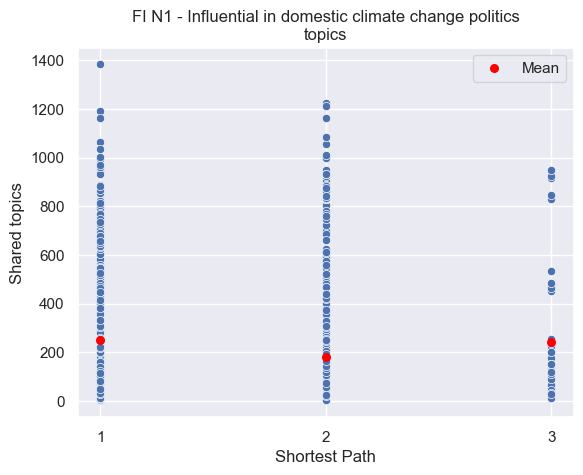

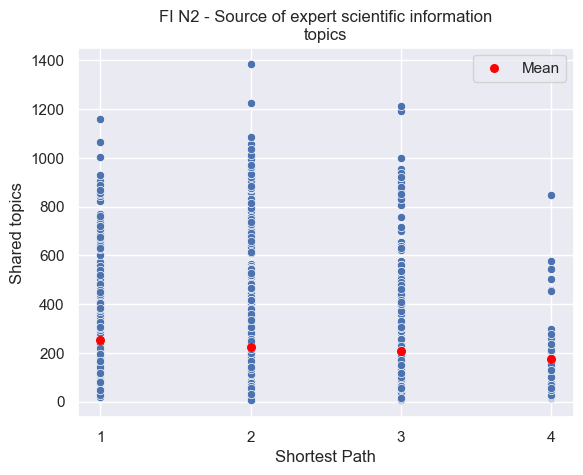

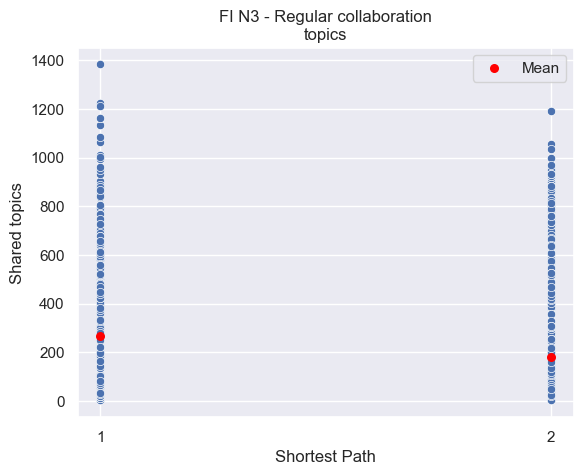

hashtags



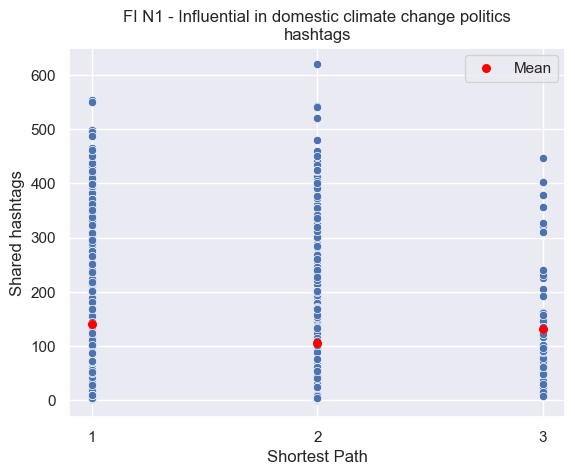

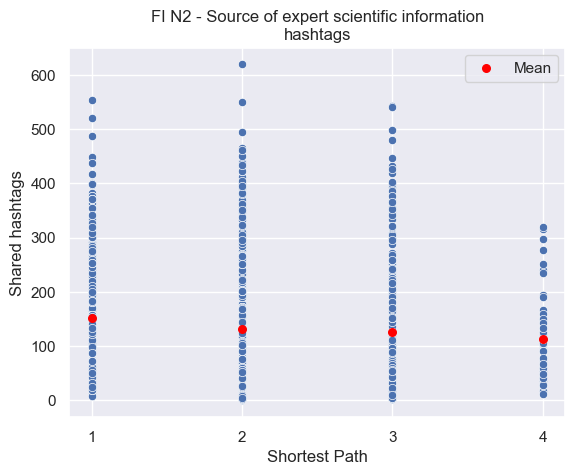

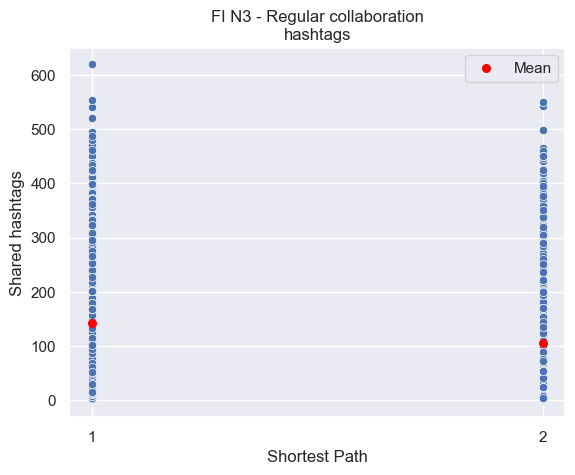

topics

N1
T-test between 2 and 1:
Mean 2 < mean 1
P-value: 2.807473747275915e-18

T-test between 2 and 3:
Mean 2 < mean 3
P-value: 0.015231973306470534


N2
T-test between 2 and 1:
Mean 2 < mean 1
P-value: 0.02045830726802746

T-test between 3 and 1:
Mean 3 < mean 1
P-value: 0.0013633497091729886

T-test between 1 and 4:
Mean 1 > mean 4
P-value: 0.005576660016457598


N3
T-test between 1 and 2:
Mean 1 > mean 2
P-value: 1.5854466565385306e-31


hashtags

N1
T-test between 2 and 1:
Mean 2 < mean 1
P-value: 1.0082560048403043e-19

T-test between 2 and 3:
Mean 2 < mean 3
P-value: 0.03314835915900676


N2
T-test between 2 and 1:
Mean 2 < mean 1
P-value: 0.0011893944023845034

T-test between 3 and 1:
Mean 3 < mean 1
P-value: 0.0001358774942485325

T-test between 1 and 4:
Mean 1 > mean 4
P-value: 0.006305441512499991


N3
T-test between 1 and 2:
Mean 1 > mean 2
P-value: 3.269071128991952e-26




In [60]:
networks("fi", fi_topics0, fi_hashtags0)

## IRELAND

In [61]:
#ie_emb = topic_modeling("ie")
ie_emb = pd.read_csv(filepath+"ie_clusters.csv", dtype=dtype_dict)

### ALL

In [106]:
ie_topics, ie_hashtags = merge_topics("ie", ie_emb)

Number of clusters: 4598
Percentage of articles without a topic:  14.32 %

                                                                                 topic  \
792          climateemergen scrutiny committee climateemergency pb4p labour government   
1036                                  data balance commit co2 annum emission 2025 2021   
1063                          dean foul emission propose carbon council ireland budget   
3915  support minister trocaire divestment fossilfuel fossilfree irldeptfinance noonan   
3916   support trocaire tomorrow dáil divestment fossilfuel fossilfree thomaspringletd   

                                               hashtags  
792   [climateemergency, climateaction, climateemergen]  
1036                             [pfg, weo17, epa_iiea]  
1063             [climatelaw, ireland2040, greendecade]  
3915               [fossilfree, fossilfuel, divestment]  
3916                     [fossilfuel, divestment, dáil]  

There are [122, 60, 49, 39, 33] twe

topics



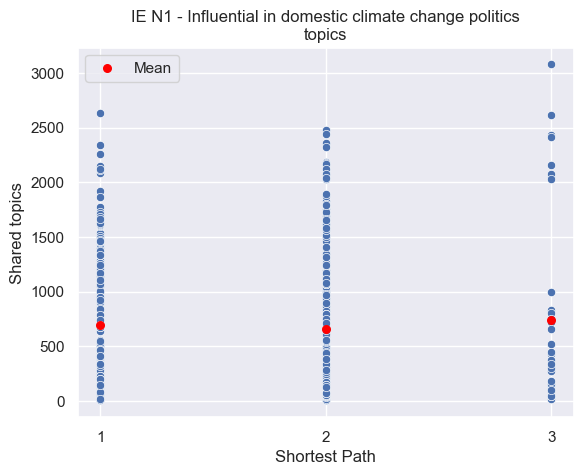

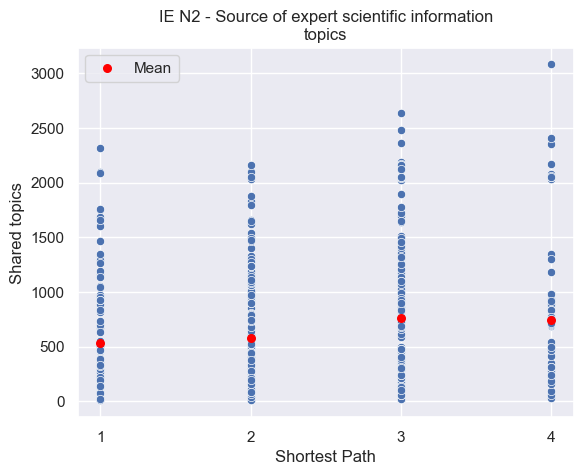

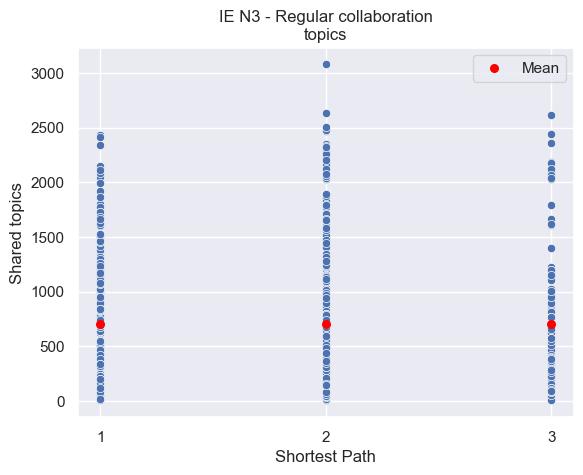

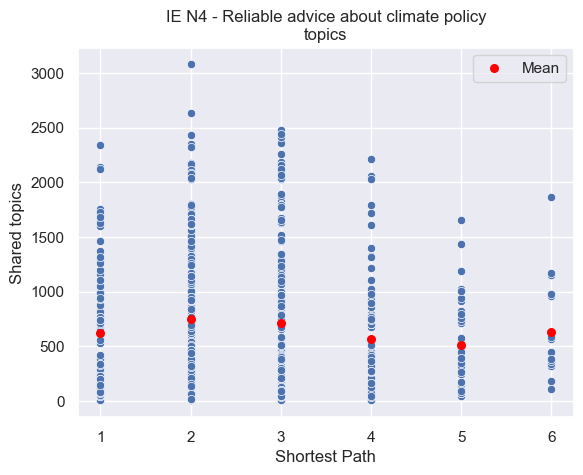

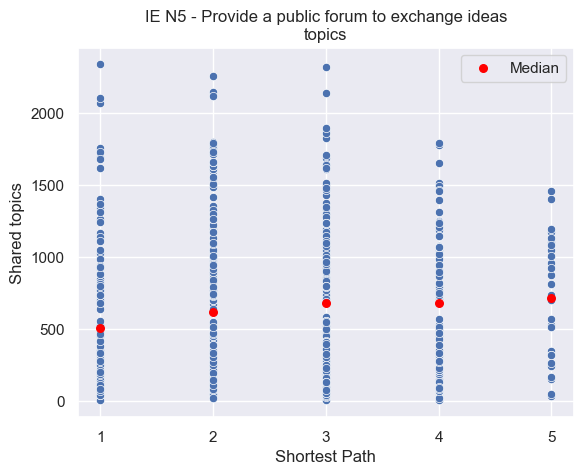

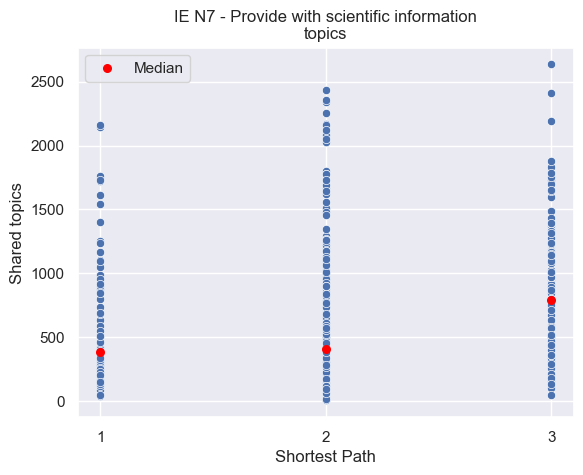

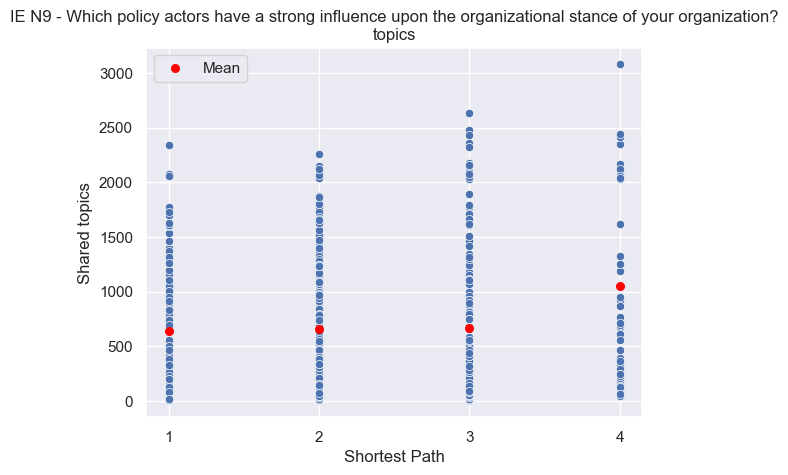

hashtags



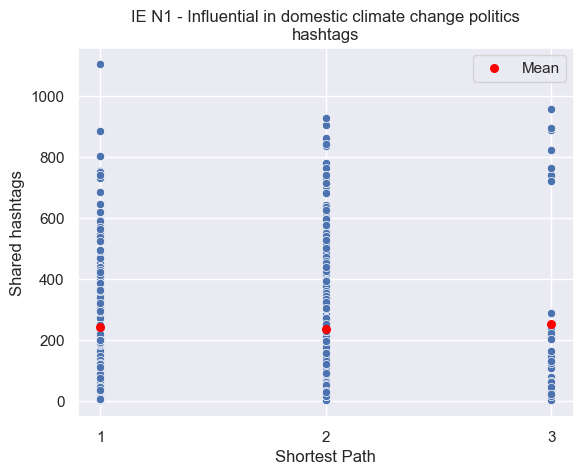

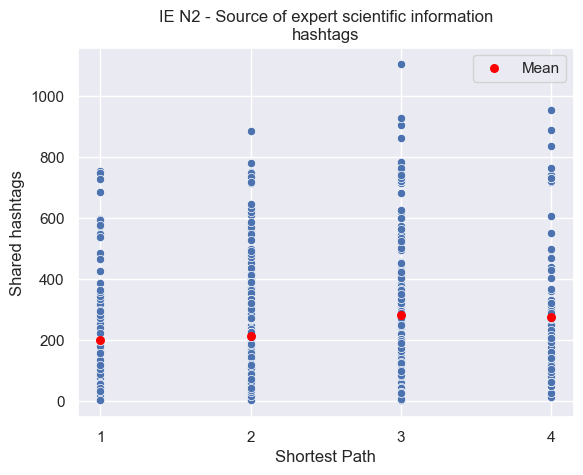

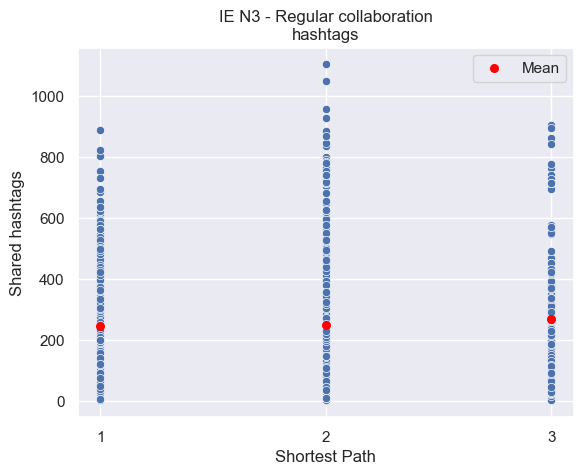

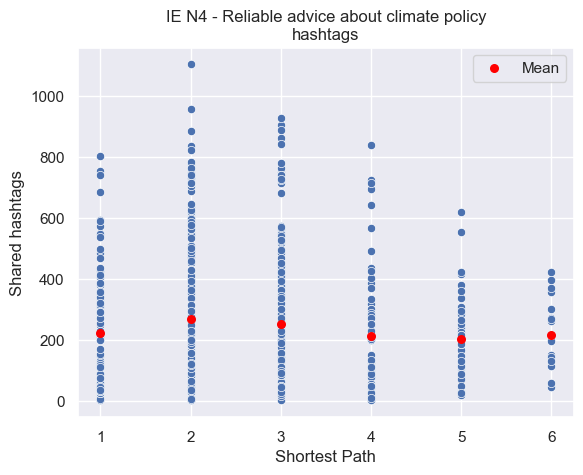

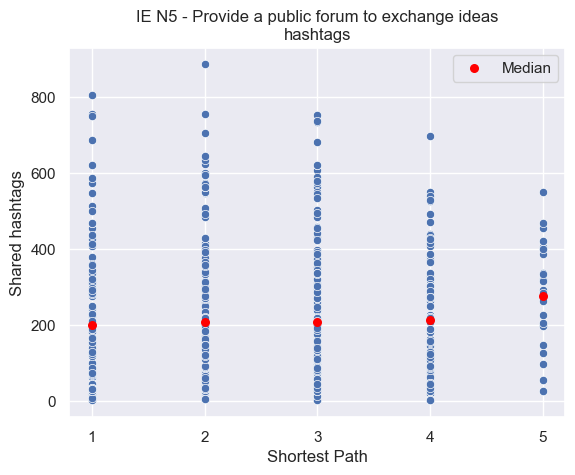

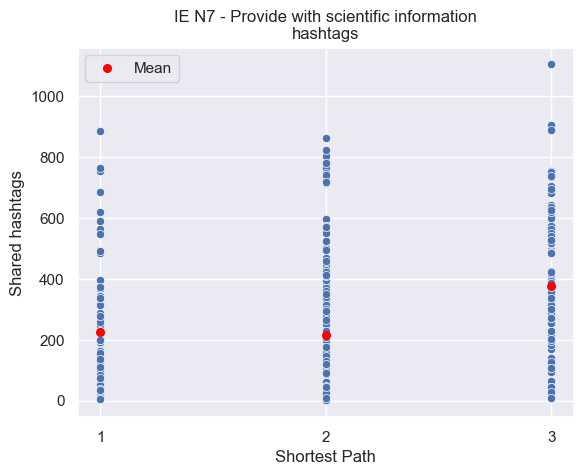

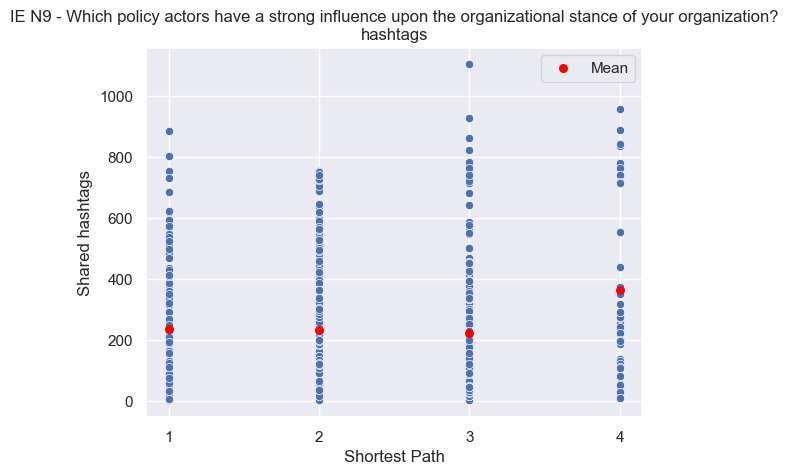

topics

N1
T-test between 1 and 2:
P-value: 0.1183

T-test between 1 and 3:
P-value: 0.6601

T-test between 2 and 3:
P-value: 0.8284


N2
T-test between 1 and 2:
P-value: 0.8186

T-test between 1 and 3:
P-value: 0.9999

T-test between 1 and 4:
P-value: 0.9974

T-test between 2 and 3:
P-value: 0.9999

T-test between 2 and 4:
P-value: 0.9958

T-test between 3 and 4:
P-value: 0.4125


N3
T-test between 1 and 2:
P-value: 0.5078

T-test between 1 and 3:
P-value: 0.5305

T-test between 2 and 3:
P-value: 0.529


N4
T-test between 1 and 2:
P-value: 0.9832

T-test between 1 and 3:
P-value: 0.9248

T-test between 1 and 4:
P-value: 0.2517

T-test between 1 and 5:
P-value: 0.1219

T-test between 1 and 6:
P-value: 0.5295

T-test between 2 and 3:
P-value: 0.192

T-test between 2 and 4:
P-value: 0.0032

T-test between 2 and 5:
P-value: 0.0061

T-test between 2 and 6:
P-value: 0.191

T-test between 3 and 4:
P-value: 0.0182

T-test between 3 and 5:
P-value: 0.017

T-test between 3 and 6:
P-value: 0.275

In [107]:
networks("ie", ie_topics, ie_hashtags)

### LEVEL 0

In [62]:
ie_topics0, ie_hashtags0 = merge_topics("ie", ie_emb, level = True)

Number of clusters: 4010
Percentage of articles without a topic:  15.02 %

                                                                                                                                         topic  \
1192                                              energyshow18 cdpalist an_c jta opendataimpact stakeh plgbc nescireland launch damien_english   
2044  kildarenatsport kildarenow kildarelibrary naastidytowns west_waterford hswaterford eastdeisegaa waterfordgaa whispersnewsltd waterfordns   
2916                                                                                          reduce dept_ecc europe affect price conflict war   
3336                                                          support minister trocaire divestment fossilfuel fossilfree irldeptfinance noonan   
3337                                                           support trocaire tomorrow dáil divestment fossilfuel fossilfree thomaspringletd   
3338                                             

topics

N1
Assumptions met

N2
Assumptions met

N3
Assumptions met

N4
Assumptions met

N5
Equal Variance NOT Satisfied 0.0621635451642041
Assumptions NOT met

N7
Equal Variance NOT Satisfied 0.2407938358749084
Assumptions NOT met

N9
Assumptions met

hashtags

N1
Assumptions met

N2
Assumptions met

N3
Assumptions met

N4
Shortest path: 6 NOT normal 0.2755025625228882
Assumptions met

N5
Shortest path: 5 NOT normal 0.2206108421087265
Equal Variance NOT Satisfied 0.9103437770993161
Assumptions NOT met

N7
Equal Variance NOT Satisfied 0.6672680613851817
Assumptions NOT met

N9
Assumptions met

topics



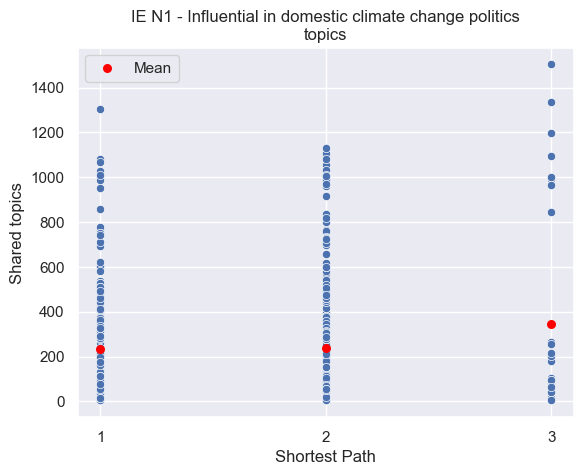

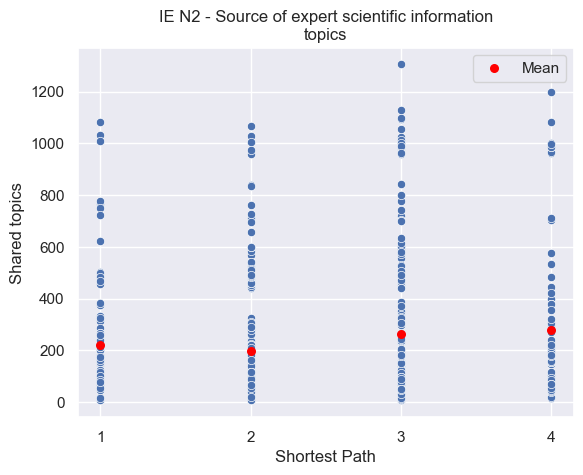

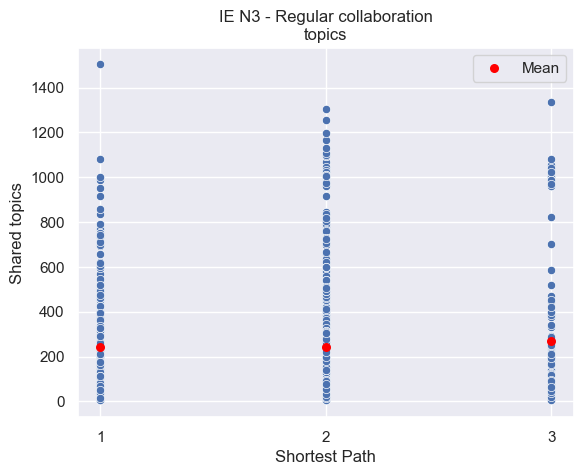

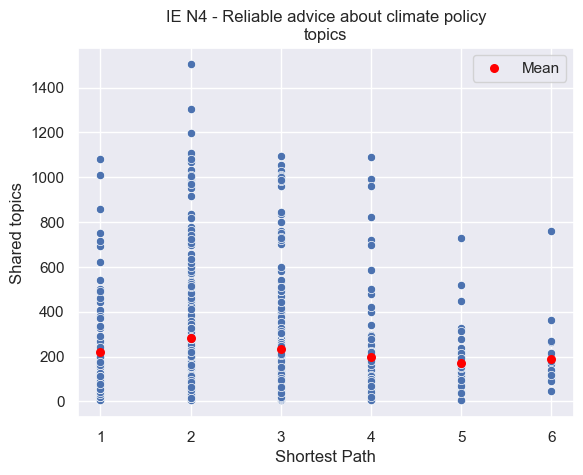

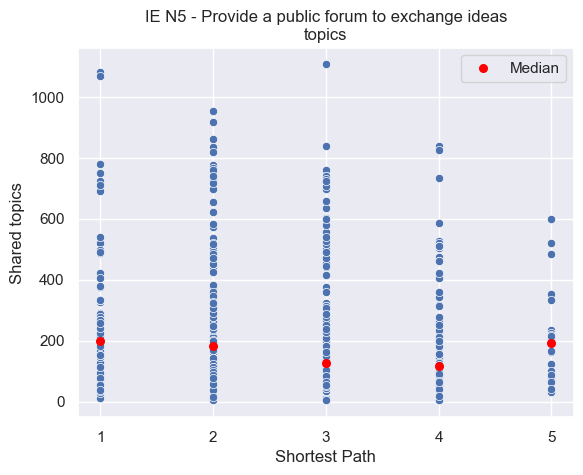

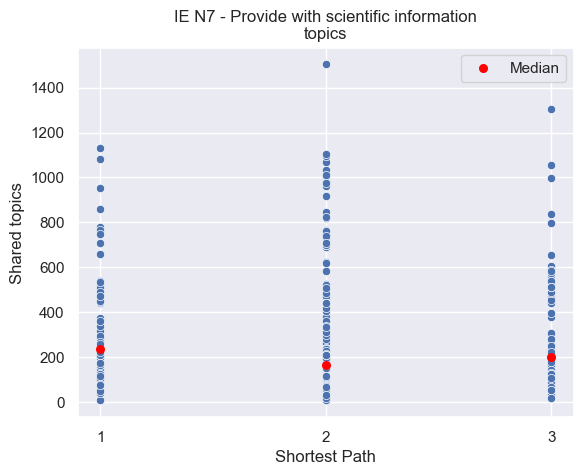

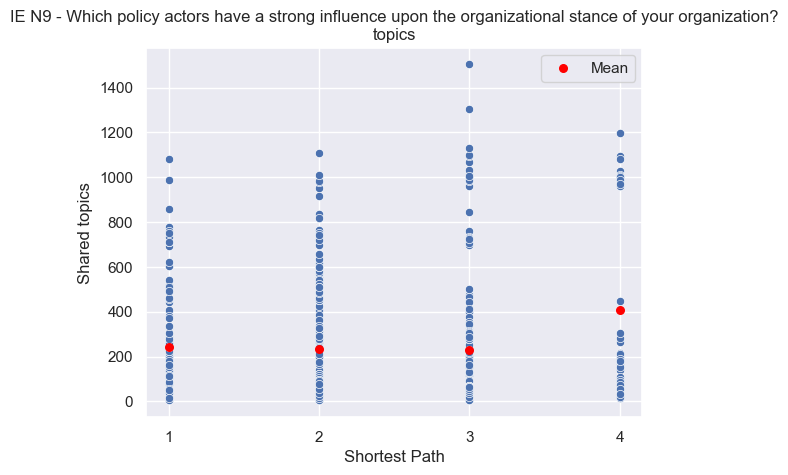

hashtags



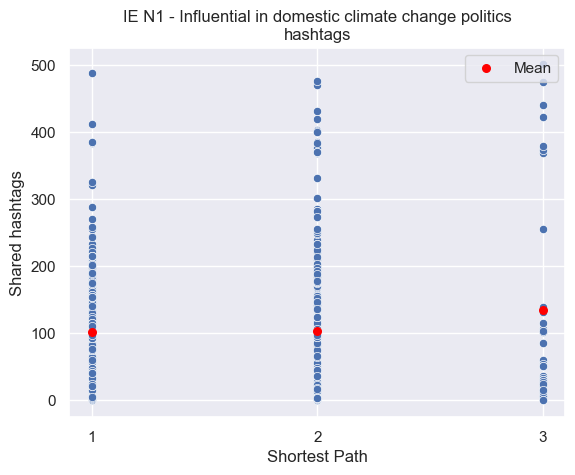

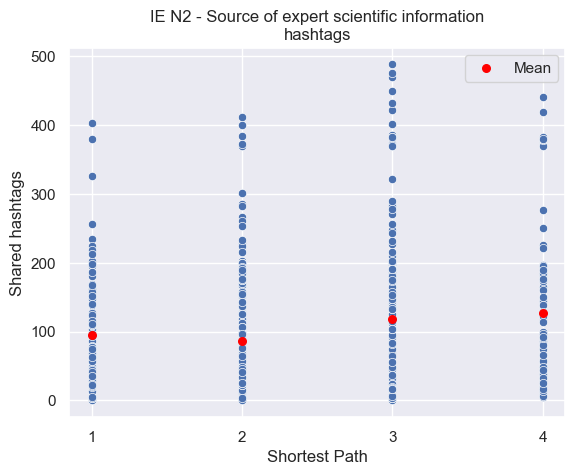

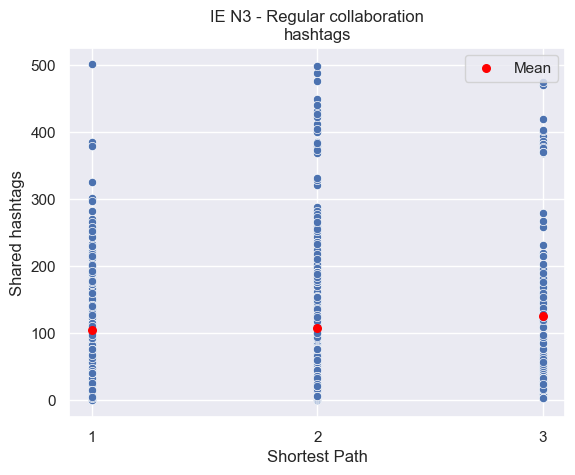

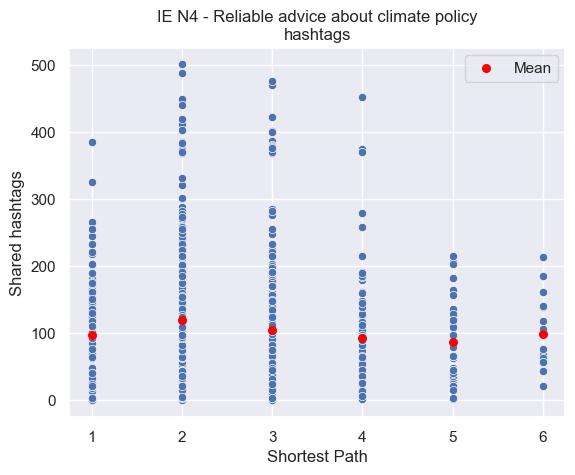

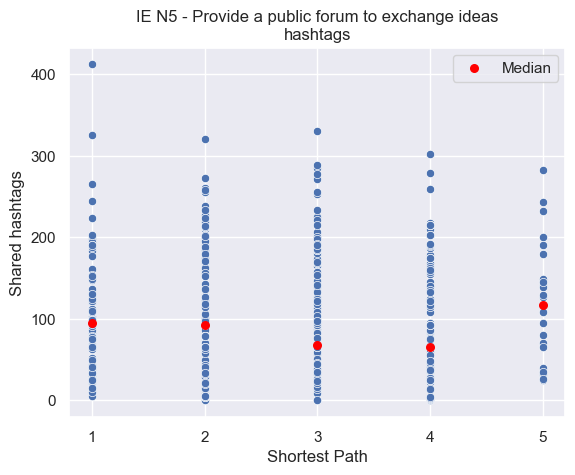

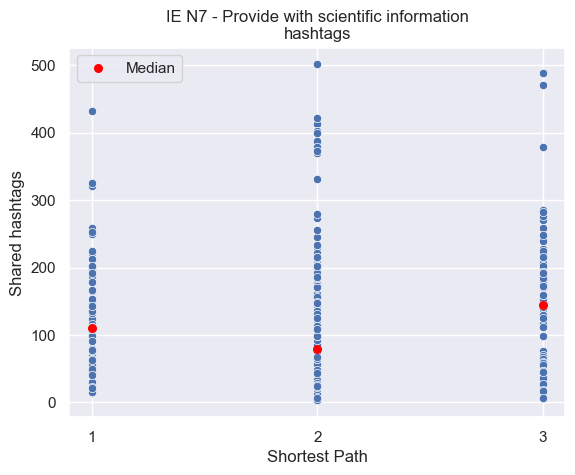

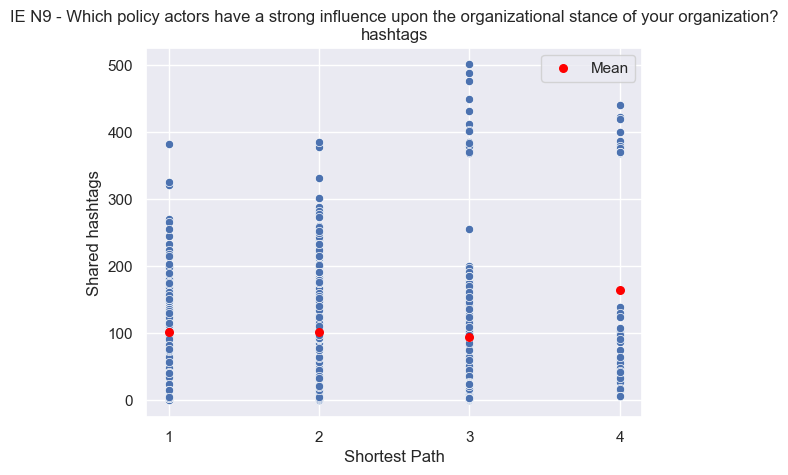

topics

N1
T-test between 2 and 3:
Mean 2 < mean 3
P-value: 0.011531561442389326

T-test between 1 and 3:
Mean 1 < mean 3
P-value: 0.008375515103671223


N2
T-test between 3 and 2:
Mean 3 > mean 2
P-value: 0.0024097168410361397

T-test between 2 and 4:
Mean 2 < mean 4
P-value: 0.003343207085923395


N3

N4
T-test between 3 and 2:
Mean 3 < mean 2
P-value: 0.017873782240829368

T-test between 2 and 5:
Mean 2 > mean 5
P-value: 0.00911227435569859

T-test between 2 and 1:
Mean 2 > mean 1
P-value: 0.024253007478772994

T-test between 2 and 4:
Mean 2 > mean 4
P-value: 0.0058838389168259


N5
Mann-Whitney U test between 2 and 3:
Median 2 > median 3
P-value: 0.007661950881752064

Mann-Whitney U test between 2 and 4:
Median 2 > median 4
P-value: 0.004774941743444368

Mann-Whitney U test between 3 and 1:
Median 3 < median 1
P-value: 0.005509936167521608

Mann-Whitney U test between 1 and 4:
Median 1 > median 4
P-value: 0.004188067301186151


N7
Mann-Whitney U test between 3 and 2:
Median 3 > med

In [63]:
networks("ie", ie_topics0, ie_hashtags0)

## SWEDEN

In [64]:
#se_emb = topic_modeling("se")
se_emb = pd.read_csv(filepath+"se_clusters.csv", dtype=dtype_dict)

### ALL

In [26]:
se_topics, se_hashtags = merge_topics("se", se_emb)

Number of clusters: 5094
Percentage of articles without a topic:  12.61 %

                                                                                          topic  \
1094                emanuelkarlsten tveklöst valutfrågne fagert reportrar nein riskerat cathrin   
1364                      forskare närheten jimmieakesson förstår traven sickla forskne utsläpp   
2902  måndag klimatpåverkande investeringar åtgärder minskar klimatklivet söka investeringsstöd   
2964                                 bridge launch climatesecurity gender hub mistrageopolitics   
3118   oljetunnor branschfråga samtl ledarskapsfråga nollutsläpp sverige 2045 behövs wwfsverige   
3703               salthalten skogslandskapen neråt jätteostronet stockholms_univ läs intensivt   
4636                                          val beroende ökar klimatdebatten bränslen fossila   

                                            hashtags  
1094                          [klimat, jämställdhet]  
1364                  

Index(['source', 'target', 'hashtags', 'topics', 'shortest_path',
       'shortest_path_cat'],
      dtype='object')


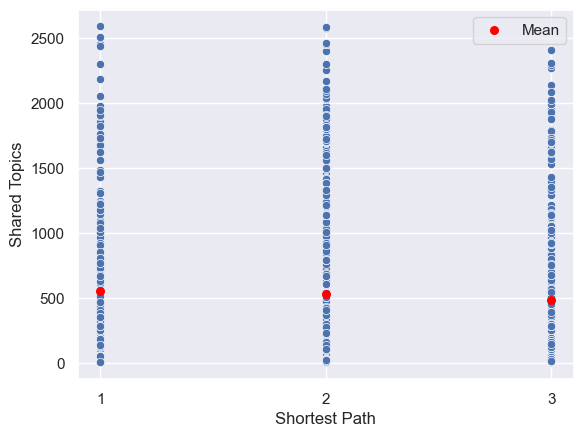

In [36]:

file = "C:\\Users\\isabe\\Desktop\\EIT\\AALTO\\1.1 RESEARCH PROJECT\\COMPON_surveys_data_integrated_0108AK.xlsx"
network_file = pd.read_excel(file, sheet_name = "network list")
all_graphs = {}

for index, row in network_file.iterrows():  
    df = pd.read_excel(file, sheet_name = "SE_N3L")
    g = nx.Graph()
    g.add_edges_from(df.values)

nodes = list(g.nodes())

nodes1 = []
nodes2 = []
distances = []

for node1 in range(len(nodes)):
    for node2 in range(len(nodes)):
        if node1 == node2:
            distance = 0
        else:
            try:
                distance = nx.shortest_path_length(g, source=nodes[node1], target=nodes[node2])
            except nx.NetworkXNoPath:
                distance = -1 

        nodes1.append(nodes[node1])
        nodes2.append(nodes[node2])
        distances.append(distance)        

df = pd.DataFrame({'org1': nodes1, 'org2': nodes2, 'shortest_path': distances})                                           


#MERGE SHORTEST PATH AND TOPICS AND HASHTAGS
metrics = pd.merge(se_topics, df, left_on=['source', 'target'], right_on=['org1', 'org2'], how='inner')
metrics.drop(['org1', 'org2'], axis=1, inplace=True)
metrics =  pd.merge(se_hashtags, metrics, on=['source', 'target'], how='inner')

#PLOT
sns.set_theme()

df_filtered = metrics[(metrics['shortest_path'] != -1) & (metrics['shortest_path'] != 4) & (metrics['shortest_path'] != 5)]
df_filtered['shortest_path_cat'] = pd.Categorical(df_filtered['shortest_path'])
print(df_filtered.columns)

sns.scatterplot(data=df_filtered, x='shortest_path', y="topics")
plt.ylabel('Shared Topics')
plt.xlabel('Shortest Path')
plt.xticks(np.arange(1, df_filtered["shortest_path"].max() + 1, 1))


mean_values = df_filtered.groupby('shortest_path')["topics"].mean()
plt.scatter(mean_values.index, mean_values.values, color='red', label='Mean', s=30)

plt.legend()
plt.show()

topics



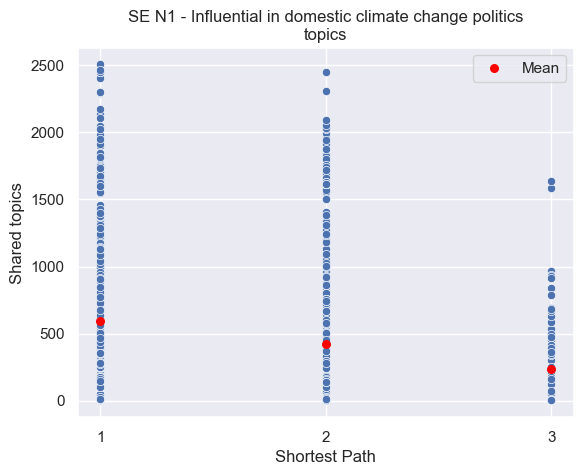

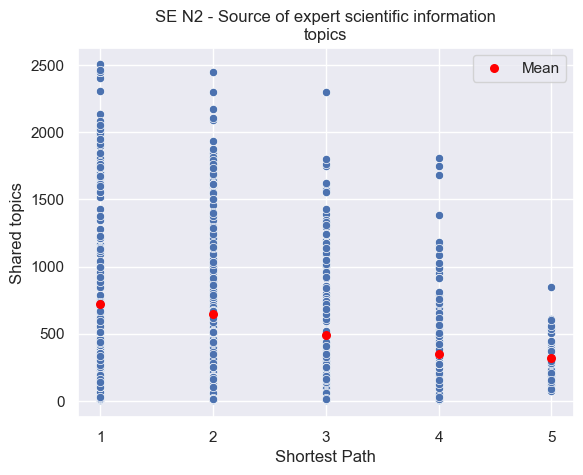

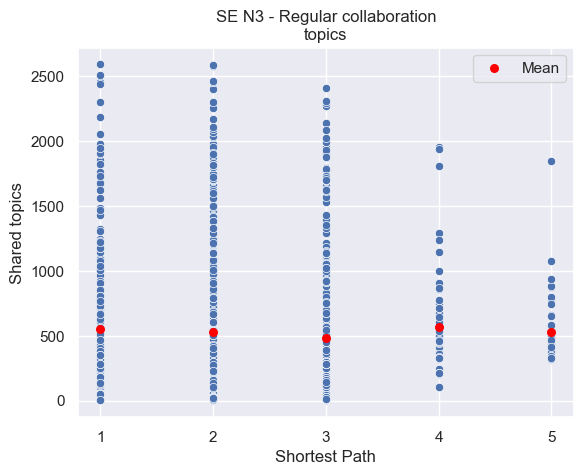

hashtags



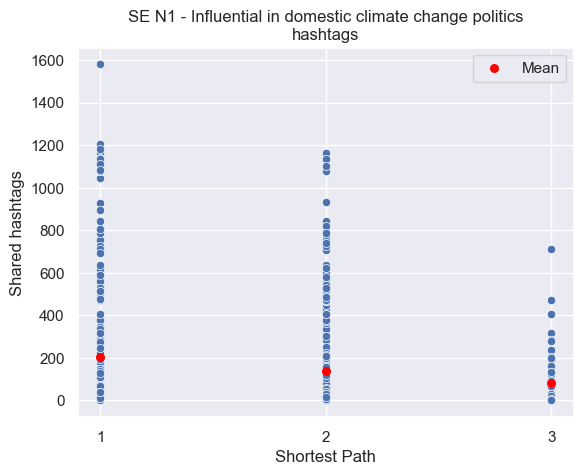

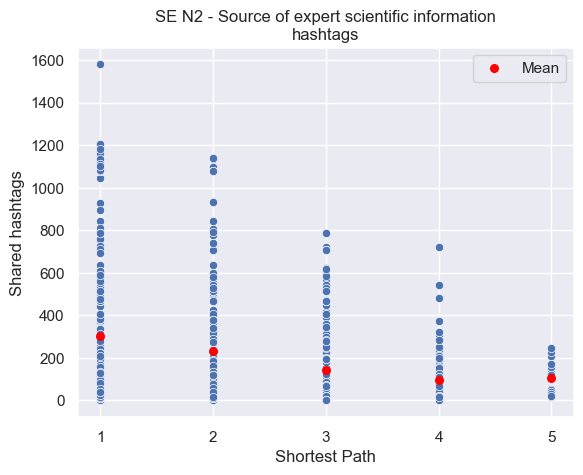

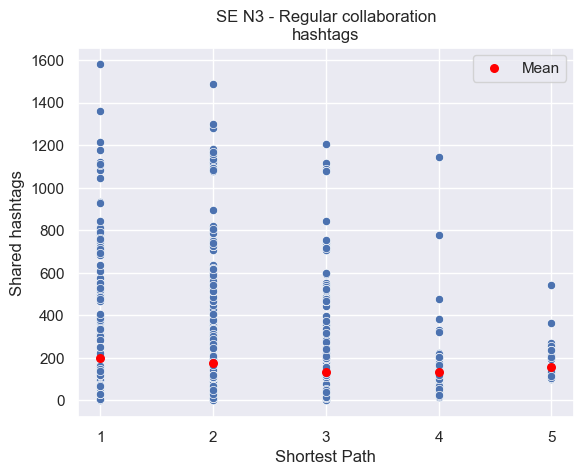

topics

N1
T-test between 1 and 2:
P-value: 0.0

T-test between 1 and 3:
P-value: 0.0

T-test between 2 and 3:
P-value: 0.0


N2
T-test between 1 and 2:
P-value: 0.0437

T-test between 1 and 3:
P-value: 0.0

T-test between 1 and 4:
P-value: 0.0

T-test between 1 and 5:
P-value: 0.0

T-test between 2 and 3:
P-value: 0.0

T-test between 2 and 4:
P-value: 0.0

T-test between 2 and 5:
P-value: 0.0001

T-test between 3 and 4:
P-value: 0.0001

T-test between 3 and 5:
P-value: 0.0065

T-test between 4 and 5:
P-value: 0.3075


N3
T-test between 1 and 2:
P-value: 0.1893

T-test between 1 and 3:
P-value: 0.0067

T-test between 1 and 4:
P-value: 0.5746

T-test between 1 and 5:
P-value: 0.4009

T-test between 2 and 3:
P-value: 0.007

T-test between 2 and 4:
P-value: 0.7454

T-test between 2 and 5:
P-value: 0.5209

T-test between 3 and 4:
P-value: 0.9467

T-test between 3 and 5:
P-value: 0.7699

T-test between 4 and 5:
P-value: 0.2896


hashtags

N1
T-test between 1 and 2:
P-value: 0.0

T-test betw

In [108]:
networks("se", se_topics, se_hashtags)

### LEVEL 0

In [65]:
se_topics0, se_hashtags0 = merge_topics("se", se_emb, level = True)

Number of clusters: 3173
Percentage of articles without a topic:  12.34 %

                                                                                                                          topic  \
712                                                                    fight effort fue internationalworkersday planet liveable   
907                           godsstrategin godsstråk godsterminal godstr godstrafik godstrafiken godset 𝘧𝘰𝘳 ipcc climatereport   
1334  klimatsverige klimatriksdagen ragnhild yay xr_swerebellion enjoyable cathartic ragnhildlarsson klimatpodden gretathunberg   
1562                                                       message spirit greta digitalstrike your keep you gretathunberg thank   
1650                                  måndag klimatpåverkande investeringar åtgärder minskar klimatklivet söka investeringsstöd   

                                                      hashtags  
712             [climatestrikeonline, internationalworkersday]  
907     

topics

N1
Assumptions met

N2
Shortest path: 5 NOT normal 0.12168563902378082
Assumptions met

N3
Assumptions met

hashtags

N1
Assumptions met

N2
Assumptions met

N3
Assumptions met

topics



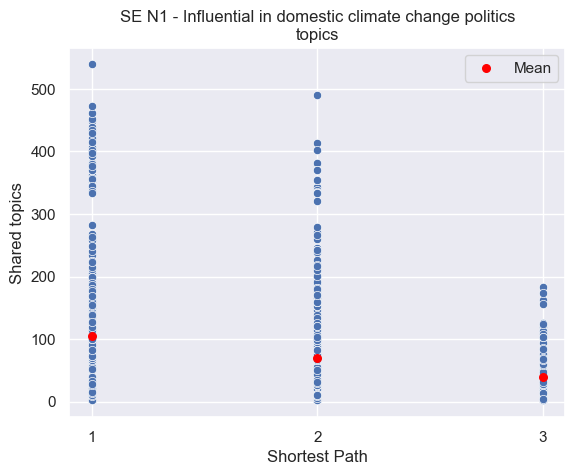

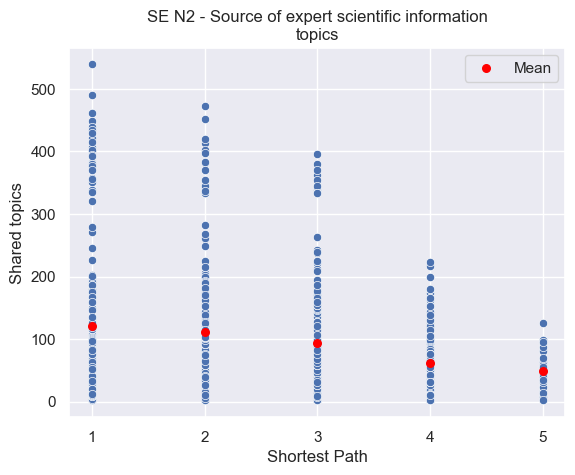

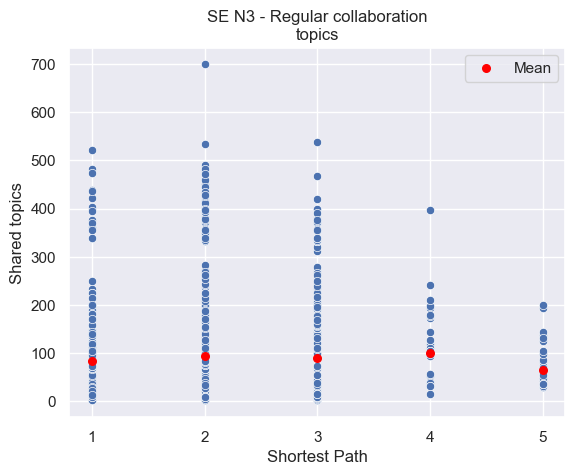

hashtags



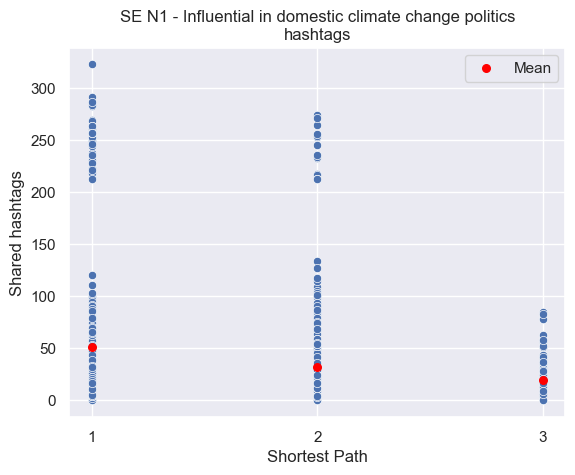

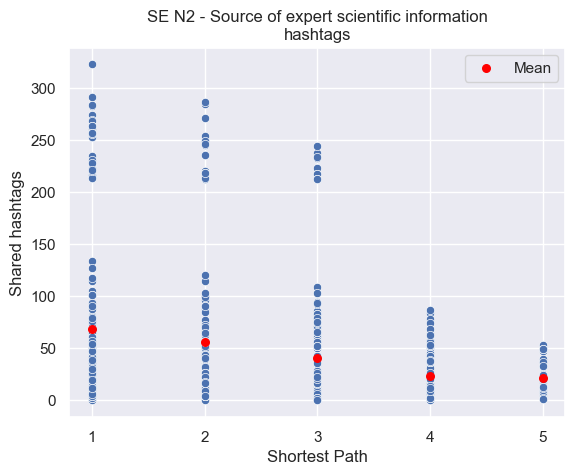

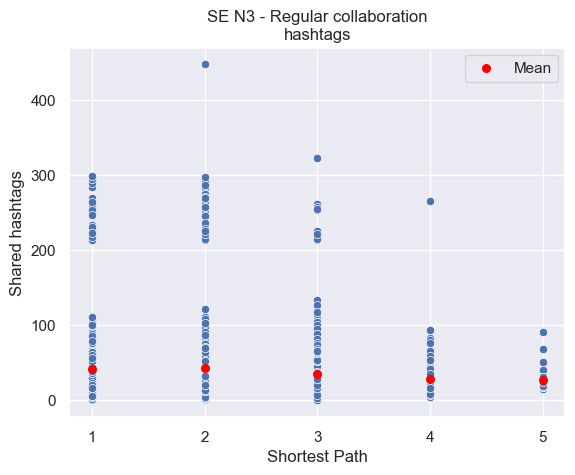

topics

N1
T-test between 2 and 1:
Mean 2 < mean 1
P-value: 1.0028337736173697e-17

T-test between 2 and 3:
Mean 2 > mean 3
P-value: 1.2447106776709632e-06

T-test between 1 and 3:
Mean 1 > mean 3
P-value: 7.1289975493282666e-12


N2
T-test between 1 and 3:
Mean 1 > mean 3
P-value: 0.004360179343213981

T-test between 1 and 4:
Mean 1 > mean 4
P-value: 1.5536865309559932e-08

T-test between 1 and 5:
Mean 1 > mean 5
P-value: 0.0004940412998186489

T-test between 3 and 2:
Mean 3 < mean 2
P-value: 0.029912899736811098

T-test between 3 and 4:
Mean 3 > mean 4
P-value: 2.828124876744907e-05

T-test between 3 and 5:
Mean 3 > mean 5
P-value: 0.0014974015245297514

T-test between 2 and 4:
Mean 2 > mean 4
P-value: 7.246831601781547e-09

T-test between 2 and 5:
Mean 2 > mean 5
P-value: 0.00015936842928109606


N3
T-test between 5 and 4:
Mean 5 < mean 4
P-value: 0.0025776255751684437


hashtags

N1
T-test between 2 and 1:
Mean 2 < mean 1
P-value: 4.201918674650246e-16

T-test between 2 and 3:
Mean

In [66]:
networks("se", se_topics0, se_hashtags0)